# Probability

## Hot Hands

Basketball players who make several baskets in succession are described as having a hot hand. Fans and players have long believed in the hot hand phenomenon, which refutes the assumption that each shot is independent of the next. However, a 1985 [paper](https://www.cs.colorado.edu/~mozer/Teaching/syllabi/7782/readings/gilovich%20vallone%20tversky.pdf) by Gilovich, Vallone, and Tversky collected evidence that contradicted this belief and showed that successive shots are independent events. This paper started a great controversy that continues to this day, as you can see by Googling hot hand basketball.

We do not expect to resolve this controversy today. However, in this lab we'll apply one approach to answering questions like this. The goals for this lab are to (1) think about the effects of independent and dependent events, (2) learn how to simulate shooting streaks in Python, and (3) to compare a simulation to actual data in order to determine if the hot hand phenomenon appears to be real.

In [1]:
# for Mac OS users only!
# if you run into any SSL certification issues, 
# you may need to run the following command for a Mac OS installation.
# $/Applications/Python 3.x/Install Certificates.command
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

## Getting started

Our investigation will focus on the performance of one player: Kobe Bryant of the Los Angeles Lakers. His performance against the Orlando Magic in the 2009 NBA finals earned him the title Most Valuable Player and many spectators commented on how he appeared to show a hot hand. Let's load some data from those games and look at the first several rows.

In [2]:
import pandas as pd

kobe = pd.read_csv('https://www.openintro.org/stat/data/kobe.csv')
kobe.head()

,vs,game,quarter,time,description,basket
0,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,ORL,1,1,7:03,Kobe Bryant makes driving layup,H


Let's check the number of games played.

In [3]:
print(kobe['game'].nunique())

5


Five games were played. NBA games are played in four quarters. However, if the score is equal at the end of the 4th quarter, overtimes are played to determine the winning team. Let's check if any game went to overtime.

In [4]:
print(kobe['quarter'].unique())

['1' '2' '3' '4' '1OT']


In [5]:
kobe[kobe['quarter'] == '1OT']

,vs,game,quarter,time,description,basket
53,ORL,2,1OT,4:13,Kobe Bryant misses 22-foot jumper,M
54,ORL,2,1OT,2:17,Kobe Bryant makes 11-foot two point shot,H
80,ORL,4,1OT,4:13,Kobe Bryant makes 11-foot jumper,H
81,ORL,4,1OT,3:32,Kobe Bryant makes 19-foot jumper,H
82,ORL,4,1OT,2:49,Kobe Bryant misses 10-foot jumper,M
83,ORL,4,1OT,1:58,Kobe Bryant misses 18-foot jumper,M
84,ORL,4,1OT,0:47,Kobe Bryant misses 15-foot jumper,M


We can see that Game 2 and Game 4 went to overtime (encoded as "1OT").

Before we begin, we need to make sure the data is properly sorted by `game` and `quarter`.

In [6]:
kobe

,vs,game,quarter,time,description,basket
0,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,ORL,1,1,7:03,Kobe Bryant makes driving layup,H
...,...,...,...,...,...,...
128,ORL,3,4,3:33,Bryant Layup Shot: Missed,M
129,ORL,3,4,2:02,Bryant 3pt Shot: Missed,M
130,ORL,3,4,00:23.9,Bryant 3pt Shot: Missed,M
131,ORL,3,4,00:06.9,Bryant 3pt Shot: Missed,M


We know that five games were played in total. Yet the last rows shows the records of Game 3. Therefore, we should sort the data by `game` and `quarter` in ascending orders.

First, let's replace "1OT" with "5" for the `quarter` column to make sorting easier.

In [7]:
kobe['quarter'] = kobe['quarter'].replace('1OT', '5') 
kobe['quarter'] = kobe['quarter'].astype(int)

Then, we can sort the data by `game` and `quarter` in ascending orders, and finally begin talking about the concept of probability.

In [8]:
kobe.sort_values(by = ['game', 'quarter'], ascending = [True, True], ignore_index = True, inplace = True)  
# Note: time is already in descending order for each game and quarter, so we do not need to sort that one.
kobe

,vs,game,quarter,time,description,basket
0,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,ORL,1,1,7:03,Kobe Bryant makes driving layup,H
...,...,...,...,...,...,...
128,ORL,5,4,6:22,Kobe Bryant misses 18-foot jumper,M
129,ORL,5,4,4:26,Kobe Bryant misses 27-foot three point jumper,M
130,ORL,5,4,3:12,Kobe Bryant misses 27-foot three point jumper,M
131,ORL,5,4,2:38,Kobe Bryant makes 9-foot two point shot,H


In this data frame, every row records a shot taken by Kobe Bryant. If he hit the shot (made a basket), a hit, `H`, is recorded in the column named basket, otherwise a miss, `M`, is recorded.

Just looking at the string of hits and misses, it can be difficult to gauge whether or not it seems like Kobe was shooting with a hot hand. One way we can approach this is by considering the belief that hot hand shooters tend to go on shooting streaks. For this lab, we define the length of a shooting streak to be the ***number of consecutive baskets made until a miss occurs***.

For example, in Game 1 Kobe had the following sequence of hits and misses from his nine shot attempts in the first quarter:

##### `H M | M | H H M | M | M | M`

To verify this use the following command:

In [9]:
kobe['basket'][0:9]

0    H
1    M
2    M
3    H
4    H
5    M
6    M
7    M
8    M
Name: basket, dtype: object

Within the nine shot attempts, there are six streaks, which are separated by a "|" above. Their lengths are one, zero, two, zero, zero, zero (in order of occurrence).

<div class = 'exercise'>
<h4>Exercise 1</h4>
What does a streak length of 1 mean, i.e. how many hits and misses are in a streak of 1? What about a streak length of 0?
</div>

The custom function `calc_streak()` can be used to calculate the lengths of all shooting streaks.

In [10]:
def calc_streak(x):
    all_shoots = list(x)
    streak, count = [], 0
    
    for shoot in all_shoots:
        if shoot == 'H':
            count += 1
        elif shoot == 'M':
            streak.append(count)
            count = 0
    
    # If the last shoot is a hit, make sure to append the last count to the streak list as well.
    if all_shoots[-1] == 'H':  
        streak.append(count)
        
    return streak  
    
kobe_streak = calc_streak(kobe['basket'])
print(kobe_streak)

[1, 0, 2, 0, 0, 0, 3, 2, 0, 3, 0, 1, 3, 0, 0, 0, 0, 0, 1, 1, 0, 4, 1, 0, 1, 0, 1, 0, 1, 4, 3, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 3, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1]


We can look at the distribution of the lengths of all shooting streaks  with a barplot.

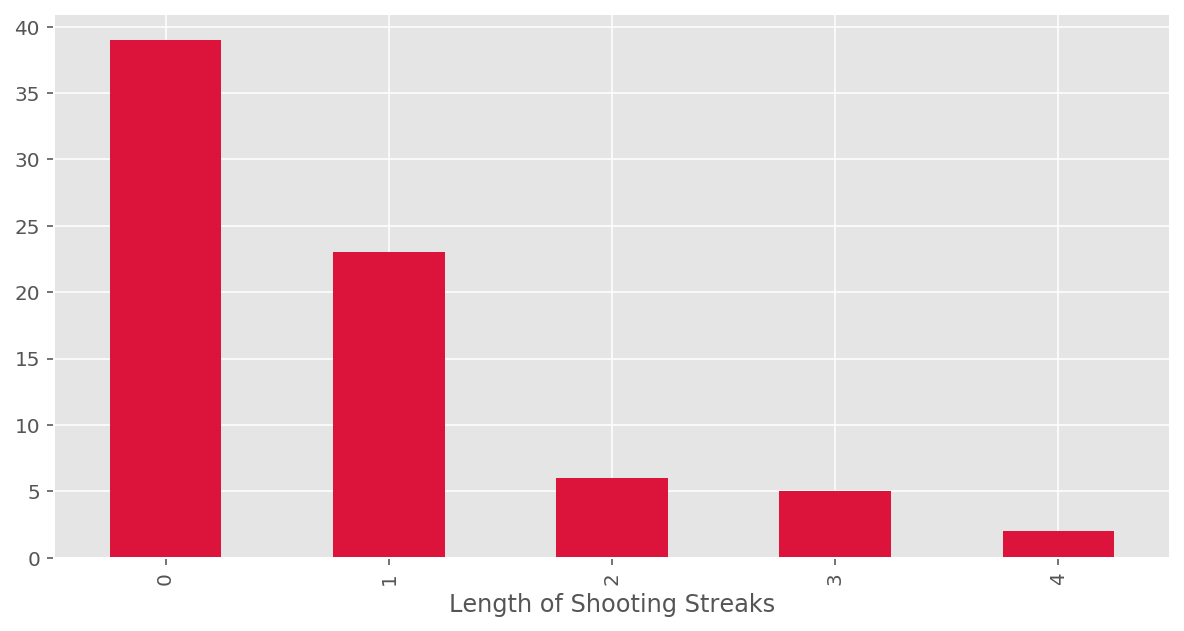

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

kobe_streak_counts = pd.Series(kobe_streak).value_counts().sort_index()

kobe_streak_counts.plot(kind = 'bar', color = 'crimson')
plt.xlabel('Length of Shooting Streaks')
plt.show(); 

Note that instead of making a histogram, we chose to make a bar plot. A bar plot is preferable here since our variable is discrete – counts – instead of continuous.

<div class = 'exercise'>
<h4>Exercise 2</h4>
Describe the distribution of Kobe's streak lengths from the 2009 NBA finals. What was his typical streak length? How long was his longest streak of baskets?
</div>

## Compared to What?

We've shown that Kobe had some long shooting streaks, but are they long enough to support the belief that he had hot hands? What can we compare them to?

To answer these questions, let's return to the idea of *independence*. Two processes are independent if the outcome of one process doesn't effect the outcome of the second. If each shot that a player takes is an independent process, having made or missed your first shot will not affect the probability that you will make or miss your second shot.

A shooter with a hot hand will have shots that are *not* independent of one another. Specifically, if the shooter makes his first shot, the hot hand model says he will have a *higher* probability of making his second shot.

Let's suppose for a moment that the hot hand model is valid for Kobe. During his career, the percentage of time Kobe makes a basket (i.e. his shooting percentage) is about 45%, or in probability notation,
#### `P(shot 1 = H) = 0.45`
If he makes the first shot and has a hot hand (not independent shots), then the probability that he makes his second shot would go up to, let's say, 60%,
#### `P(shot 2 = H|shot 1 = H) = 0.60`
As a result of these increased probabilites, you'd expect Kobe to have longer streaks. Compare this to the skeptical perspective where Kobe does *not* have a hot hand (where each shot is independent of the next). If he hit his first shot, the probability that he makes the second is still 0.45.
#### `P(shot 2 = H|shot 1 = H) = 0.45`
In other words, making the first shot did nothing to effect the probability that he'd make his second shot. If Kobe's shots are independent, then he'd have the same probability of hitting every shot regardless of his past shots: 45%.

Now that we've phrased the situation in terms of independent shots, let's return to the question: how do we tell if Kobe's shooting streaks are long enough to indicate that he has hot hands? We can compare his streak lengths to someone without hot hands: an independent shooter.

## Simulations in Python

While we don't have any data from a shooter we know to have independent shots, that sort of data is very easy to simulate in Python. In a simulation, you set the ground rules of a random process and then the computer uses random numbers to generate an outcome that adheres to those rules. As a simple example, you can simulate flipping a fair coin with the following:

In [12]:
import numpy as np

outcomes = np.array(['heads', 'tails'])
print(np.random.choice(outcomes))

heads


The vector `outcomes` can be thought of as a hat with two slips of paper in it: one slip says `heads` and the other says `tails`. The function `random.choice()` draws one slip from the hat and tells us if it was a head or a tail.

Run the second command listed above several times. Just like when flipping a coin, sometimes you'll get a heads, sometimes you'll get a tails, but in the long run, you'd expect to get roughly equal numbers of each.

If you wanted to simulate flipping a fair coin 100 times, you could either run the function 100 times or, more simply, adjust the `size` argument, which governs how many samples to draw (the `replace = True` argument indicates we put the slip of paper back in the hat before drawing again). Save the resulting array of heads and tails in a new object called sim_fair_coin.

In [13]:
sim_fair_coin = np.random.choice(outcomes, size = 100, replace = True)

To view the results of this simulation, use `unique()` to count up the number of heads and tails:

In [14]:
unique, counts = np.unique(sim_fair_coin, return_counts = True)
print(np.asarray((unique, counts)).T)

[['heads' '46']
 ['tails' '54']]


Since there are only two elements in `outcomes`, the probability that we "flip" a coin and it lands heads is 0.5. Say we're trying to simulate an unfair coin that we know only lands heads 20% of the time. We can adjust for this by adding an argument called `p`, which provides the probabilities associated with each entry in the array.

In [15]:
sim_unfair_coin = np.random.choice(outcomes, size = 100, replace = True, p = [0.2, 0.8])
unique, counts = np.unique(sim_unfair_coin, return_counts = True)
print(np.asarray((unique, counts)).T)

[['heads' '26']
 ['tails' '74']]


`p = [0.2, 0.8]` indicates that for the two elements in the outcomes array, we want to select the first one, `heads` with probability 0.2 and the second one, `tails` with probability 0.8. Another way of thinking about this is to think of the outcome space as a bag of 10 chips, where 2 chips are labeled "head" and 8 chips "tail". Therefore at each draw, the probability of drawing a chip that says "head" is 20%, and "tail" is 80%.

<div class = 'exercise'>
<h4>Exercise 3</h4>
In your simulation of flipping the unfair coin 100 times, how many flips came up heads?
</div>

In a sense, we've shrunken the size of the slip of paper that says "heads", making it less likely to be drawn and we've increased the size of the slip of paper saying "tails", making it more likely to be drawn. When we simulated the fair coin, both slips of paper were the same size. This happens by default if you don't provide a `p` argument; all elements in the `outcomes` array have an equal probability of being drawn.

## Simulating the Independent Shooter

Simulating a basketball player who has independent shots uses the same mechanism that we use to simulate a coin flip. To make a valid comparison between Kobe and our simulated independent shooter, we need to align both their shooting percentage and the number of attempted shots.

In [16]:
outcomes = np.array(['H', 'M'])
sim_basket = np.random.choice(outcomes, size = 133, replace = True, p = [0.45, 0.55])

With the results of the simulation saved as `sim_basket`, we have the data necessary to compare Kobe to our independent shooter. We can look at Kobe's data alongside our simulated data.

In [17]:
print(np.array(kobe['basket']))

['H' 'M' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'H' 'M' 'H' 'H' 'M' 'M' 'H'
 'H' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'H'
 'M' 'M' 'H' 'H' 'H' 'H' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'M'
 'H' 'H' 'H' 'H' 'M' 'H' 'H' 'H' 'M' 'H' 'M' 'H' 'M' 'M' 'M' 'M' 'M' 'M'
 'H' 'M' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'H' 'M'
 'M' 'M' 'H' 'M' 'M' 'M' 'M' 'H' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'H' 'M'
 'M' 'M' 'M' 'H' 'H' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'H' 'M'
 'M' 'H' 'M' 'M' 'M' 'H' 'M']


In [18]:
print(sim_basket)  # Notice that every time you rerun the simulation above, the results of sim_basket changes.

['M' 'H' 'M' 'M' 'H' 'M' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'H' 'M' 'M' 'M' 'H' 'M' 'M' 'M' 'H' 'H' 'H'
 'M' 'H' 'M' 'H' 'H' 'M' 'M' 'H' 'H' 'H' 'M' 'H' 'M' 'M' 'M' 'H' 'M' 'M'
 'H' 'H' 'M' 'M' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'H'
 'M' 'M' 'M' 'H' 'H' 'H' 'M' 'H' 'H' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'H' 'H' 'H' 'M' 'H' 'H' 'M' 'H' 'H' 'H' 'M' 'H' 'M' 'M' 'H' 'H' 'H'
 'M' 'M' 'M' 'H' 'H' 'M' 'H' 'M' 'H' 'M' 'H' 'M' 'H' 'M' 'H' 'M' 'H' 'H'
 'M' 'M' 'M' 'H' 'M' 'M' 'M']


Both data sets represent the results of 133 shot attempts, each with the same shooting percentage of 45%. We know that our simulated data is from a shooter that has independent shots. That is, we know the simulated shooter does not have a hot hand.

---
## On Your Own
### Comparing Kobe Bryant to the Independent Shooter

Using `calc_streak()`, compute the streak lengths of `sim_basket`.

<ol>
  <li>Describe the distribution of streak lengths. What is the typical streak length for this simulated independent shooter with a 45% shooting percentage? How long is the player's longest streak of baskets in 133 shots?</li><br>
  <li>If you were to run the simulation of the independent shooter a second time, how would you expect its streak distribution to compare to the distribution from the question above? Exactly the same? Somewhat similar? Totally different? Explain your reasoning.</li><br>
      <li>How does Kobe Bryant's distribution of streak lengths compare to the distribution of streak lengths for the simulated shooter? Using this comparison, do you have evidence that the hot hand model fits Kobe's shooting patterns? Explain.</li>
</ol>

<div class = "license">
This lab was adapted by Vural Aksakalli and Imran Ture from OpenIntro by Andrew Bray and Mine Çetinkaya-Rundel.
</div>

***
www.featureranking.com

### Q1. Describe the distribution of streak lengths. What is the typical streak length for this simulated independent shooter with a 45% shooting percentage? How long is the player's longest streak of baskets in 133 shots?

In [19]:
# To print the lengths of all shooting streaks of simulation 1
sim_basket_streak = calc_streak(sim_basket)
print(sim_basket_streak)

[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 1, 2, 0, 3, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 3, 1, 0, 3, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 0]


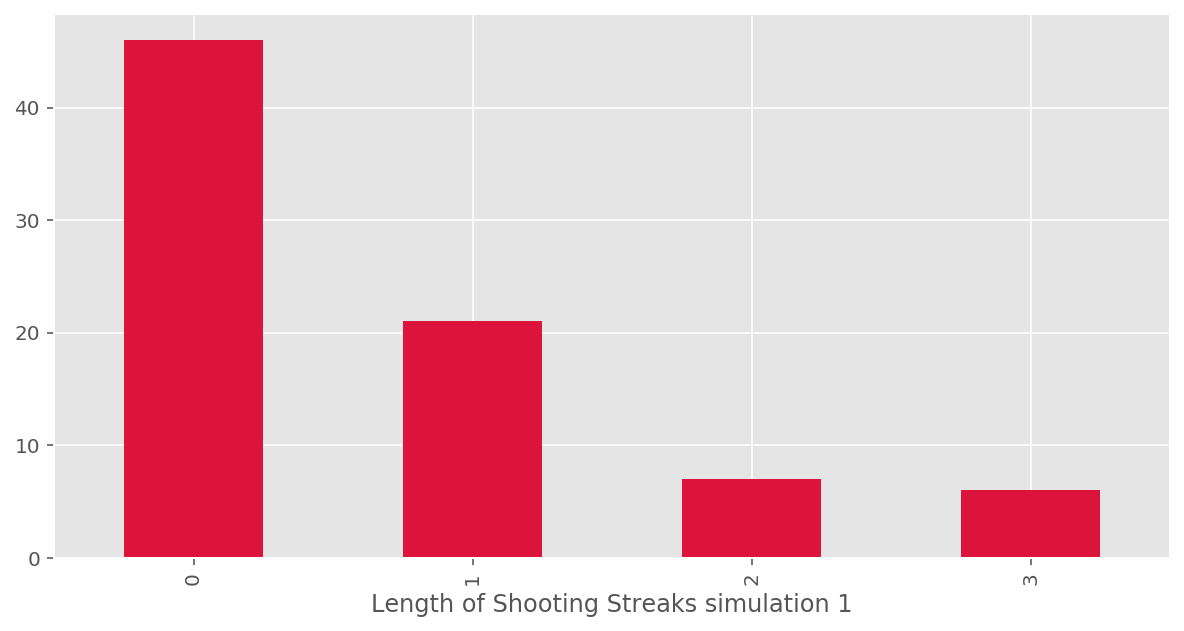

In [20]:
# Using bar chart to illustrate the simulation 1
sim_streak_counts = pd.Series(sim_basket_streak).value_counts().sort_index()

sim_streak_counts.plot(kind = 'bar', color = 'crimson')
plt.xlabel('Length of Shooting Streaks simulation 1')
plt.show(); 

### Answer of Q1

THe distribution of simulation streak length is right skew and is a unimodal. The typical streak length is 1. The longest streak is 3 (If I run again, the longest streak will be change).

### Q2. If you were to run the simulation of the independent shooter a second time, how would you expect its streak distribution to compare to the distribution from the question above? Exactly the same? Somewhat similar? Totally different? Explain your reasoning.

Next, I will run the random and use 45% probability to simulation the basketball shot.

In [21]:
# Using 45% probability to get random 
sim_basket_2 = np.random.choice(outcomes, size = 133, replace = True, p = [0.45, 0.55])
sim_basket_2

array(['M', 'M', 'M', 'H', 'M', 'M', 'H', 'H', 'M', 'H', 'M', 'H', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'H', 'H', 'M', 'M', 'M', 'M', 'H',
       'M', 'M', 'M', 'M', 'M', 'H', 'M', 'H', 'H', 'M', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'H', 'H', 'M', 'H', 'M', 'M', 'M', 'H', 'M',
       'H', 'M', 'M', 'M', 'H', 'H', 'M', 'M', 'H', 'M', 'H', 'H', 'M',
       'M', 'M', 'H', 'H', 'M', 'H', 'H', 'H', 'H', 'M', 'M', 'H', 'M',
       'H', 'H', 'H', 'H', 'M', 'M', 'H', 'M', 'H', 'H', 'M', 'M', 'M',
       'H', 'M', 'M', 'H', 'M', 'M', 'M', 'H', 'M', 'H', 'M', 'H', 'M',
       'H', 'M', 'H', 'M', 'H', 'M', 'M', 'M', 'H', 'M', 'H', 'H', 'M',
       'M', 'M', 'M', 'M', 'M', 'H', 'M', 'M', 'H', 'M', 'M', 'H', 'H',
       'M', 'M', 'H'], dtype='<U1')

In [22]:
# To print the lengths of all shooting streaks of simulation 2
sim_basket_streak_2 = calc_streak(sim_basket_2)
print(sim_basket_streak_2)

[0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 9, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 4, 0, 1, 4, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1]


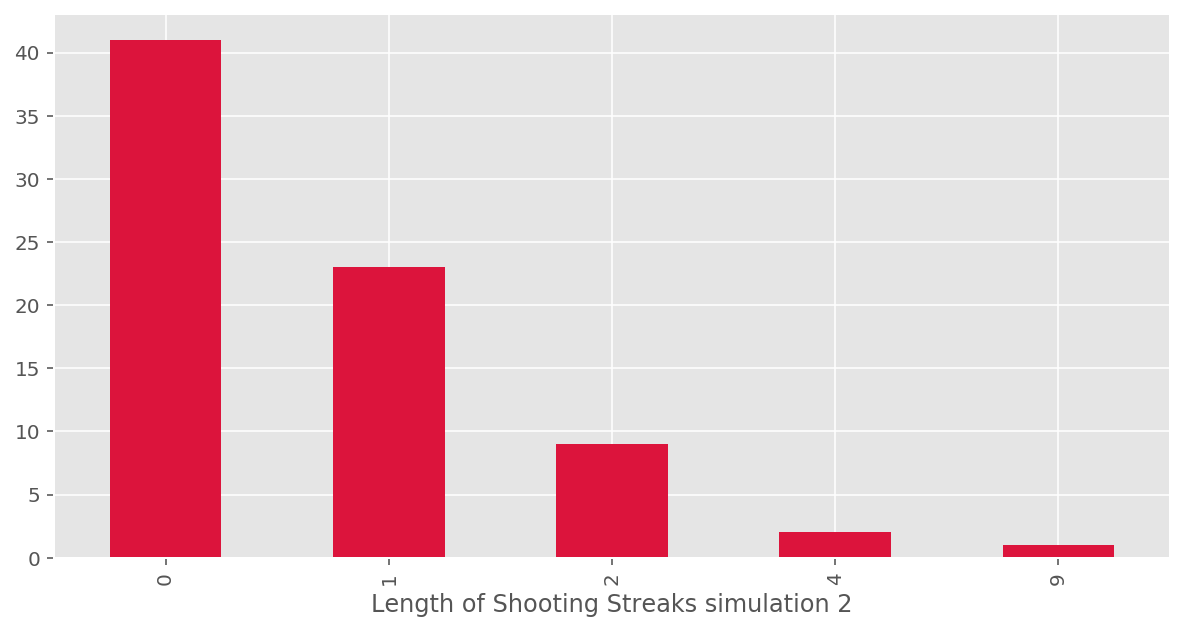

In [23]:
# Using bar chart to illustrate the simulation 2
sim_streak_counts_2 = pd.Series(sim_basket_streak_2).value_counts().sort_index()

sim_streak_counts_2.plot(kind = 'bar', color = 'crimson')
plt.xlabel('Length of Shooting Streaks simulation 2')
plt.show(); 

### Answer of Q2

If I run the simulation a second time, I would expect the distribution is similar to the first simulation distribution. I use the same 45% of probability to simulate the "hot hand" with a random sample and it is a independent event, so the distribution of simulation 1 and simulation 2 would be similar.

### Q3. How does Kobe Bryant's distribution of streak lengths compare to the distribution of streak lengths for the simulated shooter? Using this comparison, do you have evidence that the hot hand model fits Kobe's shooting patterns? Explain.

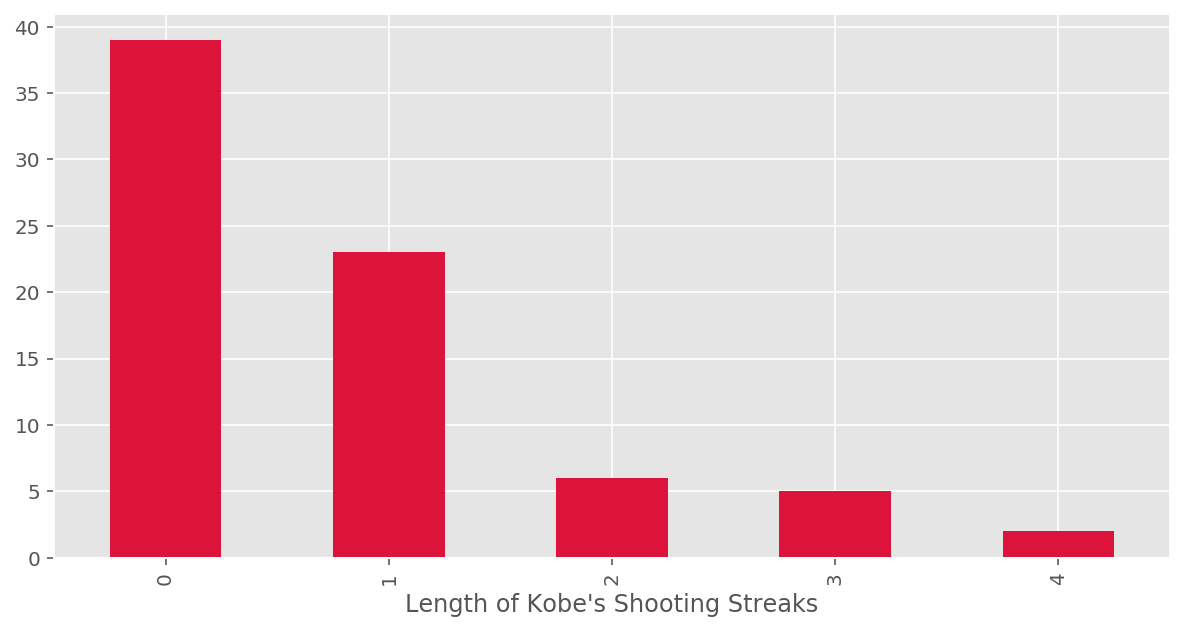

In [24]:
# to show the Kobe's Shooting streaks
kobe_streak_counts.plot(kind = 'bar', color = 'crimson')
plt.xlabel('Length of Kobe\'s Shooting Streaks')
plt.show(); 

### Answer of Q3


The sim1, sim2 and Kobe have a similar distribution. They are all right skew and unimodal. They all have similar tpyical streak length. The number of streak length 2 of simulation 2 is higher than Kobe's streak length 2.


To summary, I do not find out any evidence that Kobe has the "hot hand". The each shots are independent.